## Util Funs

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Prospect

In [2]:


def prospect(x, α, β, λ):
    if x >= 0:
        return np.log(1 + α * x)
    else:
        return -λ * np.log(1 - β * x)



### PLTS

In [4]:

class PLTS:
    def __init__(self, terms, max_scale=7, symmetric_scale=True, weight=1):
        self.terms = terms
        self.max_scale = (
            max_scale  # The maximum scale index used for flipping the scale
        )
        self.symmetric_scale = (
            symmetric_scale  # True if the scale has both positive and negative values
        )
        # self.weight = weight
        self.normalize()

    def normalize(self):
        # total_prob = sum(self.terms.values())
        # self.terms = {scale: prob / total_prob for scale, prob in self.terms.items()}
        # """Normalize the PLTS only if it has more than one element."""
        if len(self.terms) > 1:
            total_prob = sum(self.terms.values())
            if total_prob > 0:
                self.terms = {
                    scale: prob / total_prob for scale, prob in self.terms.items()
                }
            # else:
            # If the total probability is zero, assign a neutral term
            # self.terms = {"s0": 1.0}

    def apply_weight(self, weight):
        """Apply a weight to all scale indices in the PLTS."""
        weighted_terms = {}
        for scale, prob in self.terms.items():
            scale_index = self.extract_scale_index(scale)
            weighted_index = scale_index * weight
            weighted_scale = (
                f"s{weighted_index}"
                if weighted_index >= 0
                else f"s-{abs(weighted_index)}"
            )
            weighted_terms[weighted_scale] = prob
        return PLTS(weighted_terms, self.max_scale, self.symmetric_scale)

    def flip_scale(self, scale):
        # Flip the scale index according to the rules for positive and negative indices
        index = self.extract_scale_index(scale)
        if self.symmetric_scale:
            # For symmetric scales, flip the scale by negating the index
            return "s" + str(0 - index)
        else:
            # For all positive scales, flip the scale within the range
            return "s" + str(self.max_scale - index - 1)

    def extract_scale_index(self, scale):
        """从标度字符串中提取下标，考虑负数情况"""
        if scale.startswith("s-"):
            return float(scale[1:])
        else:
            return float(scale[1:])

    def multiply_with(self, other, weight_factor=1.5):
        """乘法运算，并应用权重因子"""
        combined_terms = self.terms.copy()
        for scale, prob in other.terms.items():
            scale_index = self.extract_scale_index(scale)
            if scale in combined_terms:
                combined_terms[scale] *= prob * weight_factor
            else:
                combined_terms[scale] = prob
        result = PLTS(combined_terms)
        # result.normalize()
        return result

    def add_with(self, other, weight_factor=1):
        """加法运算，并应用权重因子"""
        combined_terms = self.terms.copy()
        for scale, prob in other.terms.items():
            scale_index = self.extract_scale_index(scale)
            if scale in combined_terms:
                # a+b
                # combined_terms[scale] += prob * weight_factor
                # 使用a+b-a*b形式计算概率
                combined_terms[scale] = (
                    combined_terms[scale] + prob - combined_terms[scale] * prob
                )
            else:
                combined_terms[scale] = prob
        result = PLTS(combined_terms)
        # result.normalize()
        return result

    def subtract_with(self, other):
        """Subtract another PLTS from this one."""
        result_terms = self.terms.copy()

        # Subtract matching scales using the a - a*b rule
        for scale, prob in other.terms.items():
            if scale in result_terms:
                result_terms[scale] -= result_terms[scale] * prob
            else:
                # Flip the scale index for non-matching scales
                flipped_scale = self.flip_scale(scale)
                # If the flipped scale is present, subtract from it
                if flipped_scale in result_terms:
                    result_terms[flipped_scale] -= result_terms[flipped_scale] * prob
                else:
                    # If not, add the flipped scale with a negative probability
                    result_terms[flipped_scale] = prob

        # Normalize the result to remove negative probabilities and ensure the sum is 1
        result_plts = PLTS(result_terms, self.max_scale, self.symmetric_scale)
        result_plts.normalize()
        return result_plts

    def score(self):
        """计算PLTS的加权平均"""
        weighted_sum = sum(
            self.extract_scale_index(scale) * prob for scale, prob in self.terms.items()
        )
        return weighted_sum

    @staticmethod
    def operate_all(plts_list, operation, weight_factor=1.5):
        """对多个PLTS进行操作（乘法或加法）"""
        if not plts_list:
            return PLTS({})

        result = plts_list[0]
        for plts in plts_list[1:]:
            result = operation(result, plts, weight_factor)

        result.normalize()
        return result

    @staticmethod
    def traverse_addition(plts_list):
        """对PLTS的所有元素进行遍历加法，包括语言标度的下标相加"""
        combined_terms = {}
        for i, plts1 in enumerate(plts_list):
            for scale1, prob1 in plts1.terms.items():
                for j, plts2 in enumerate(plts_list):
                    if i != j:  # 确保不与自身组合
                        for scale2, prob2 in plts2.terms.items():
                            scale_index1 = plts1.extract_scale_index(scale1)
                            scale_index2 = plts2.extract_scale_index(scale2)
                            new_scale_index = scale_index1 + scale_index2
                            new_scale = "s" + str(new_scale_index)
                            # combined_terms[new_scale] = (
                            #     combined_terms.get(new_scale, 0) + prob1 + prob2
                            # )
                            # a+b-a*b
                            combined_terms[new_scale] = (
                                combined_terms.get(new_scale, 0)
                                + prob1
                                + prob2
                                - combined_terms.get(new_scale, 0) * (prob1 + prob2)
                            )

        result = PLTS(combined_terms)
        result.normalize()
        return result


### PLTS Evaluation Matrix


In [5]:

class PLTSEvaluationMatrix:
    def __init__(self, plts_matrix, weights, max_scale=7, symmetric_scale=True):
        self.plts_matrix = (
            plts_matrix  # Matrix of PLTS objects for each scheme and criterion
        )
        self.weights = weights  # Weights for each criterion
        self.max_scale = max_scale  # Maximum scale index
        self.symmetric_scale = (
            symmetric_scale  # Indicates if scales include negative values
        )

    def calculate_SM_for_scheme(self, scheme_plts):
        """Calculate the evaluation matrix for a single scheme according to the formula"""
        num_criteria = len(self.weights)

        scheme_matrix = np.empty((num_criteria, num_criteria), dtype=object)

        score_matrix = np.zeros((num_criteria, num_criteria))

        for j in range(num_criteria):
            for k in range(num_criteria):
                # Calculate the score for each PLTS
                xij_score = scheme_plts[j].score()
                xik_score = scheme_plts[k].score()

                # Calculate the terms based on the given formula
                if j != k:
                    diff = (self.weights[j] * xij_score) - (self.weights[k] * xik_score)
                    # term = f"s{diff}" if diff >= 0 else f"s-{abs(diff)}"
                    if diff >= 0:
                        a1 = scheme_plts[j].apply_weight(self.weights[j])
                        a2 = scheme_plts[k].apply_weight(self.weights[k])
                        scheme_matrix[j][k] = a1.subtract_with(a2)
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                else:
                    if xij_score >= 0:
                        # pass
                        scheme_matrix[j][k] = scheme_plts[j]
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})

                scheme_matrix[j][k].normalize()  # Normalize the PLTS in the matrix

        for i in range(num_criteria):
            for j in range(num_criteria):
                score_matrix[i, j] = scheme_matrix[i, j].score()
                # if score_matrix[i, j]:
                #     score_matrix[i, j] = scheme_matrix[i, j].score()
                # else:
                #     score_matrix[i, j] = 0

            return scheme_matrix, score_matrix

    def calculate_IM_for_scheme(self, scheme_plts):
        """Calculate the evaluation matrix for a single scheme according to the formula"""
        num_criteria = len(self.weights)
        scheme_matrix = np.empty((num_criteria, num_criteria), dtype=object)
        score_matrix = np.zeros((num_criteria, num_criteria))

        for j in range(num_criteria):
            for k in range(num_criteria):
                # Calculate the score for each PLTS
                xij_score = scheme_plts[j].score()
                xik_score = scheme_plts[k].score()

                # Calculate the terms based on the given formula
                if j != k:
                    diff = (self.weights[j] * xij_score) - (self.weights[k] * xik_score)
                    # term = f"s{diff}" if diff >= 0 else f"s-{abs(diff)}"
                    if diff <= 0:
                        a1 = scheme_plts[j].apply_weight(self.weights[j])
                        a2 = scheme_plts[k].apply_weight(self.weights[k])
                        scheme_matrix[j][k] = a1.subtract_with(a2)
                    else:
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                        # pass
                else:
                    if xij_score >= 0:
                        # scheme_matrix[j][k] = PLTS({"sSelf": 1})
                        scheme_matrix[j][k] = scheme_plts[j]
                        # pass
                    else:
                        # pass
                        scheme_matrix[j][k] = PLTS({"s0": 0})
                        # scheme_matrix[j][k] = PLTS({"sNon": 1})

                scheme_matrix[j][k].normalize()  # Normalize the PLTS in the matrix

        for i in range(num_criteria):
            for j in range(num_criteria):
                score_matrix[i, j] = scheme_matrix[i, j].score()
                # if score_matrix[i, j]:
                #     score_matrix[i, j] = scheme_matrix[i, j].score()
                # else:
                #     score_matrix[i, j] = 0

        return scheme_matrix, score_matrix

    def calculate_matrices_SM(self):
        """Calculate the evaluation matrices for all schemes"""
        num_schemes = len(self.plts_matrix)
        num_criteria = len(self.weights)
        # all_matrices = np.empty([num_schemes, num_criteria, num_criteria])
        all_matrices = []

        for i in range(num_schemes):
            _, scheme_matrix = self.calculate_SM_for_scheme(self.plts_matrix[i])
            all_matrices.append(scheme_matrix)
            # all_matrices[i, :, :] = scheme_matrix

        return all_matrices

    def calculate_matrices_IM(self):
        """Calculate the evaluation matrices for all schemes"""
        num_schemes = len(self.plts_matrix)
        all_matrices = []

        for i in range(num_schemes):
            _, scheme_matrix = self.calculate_IM_for_scheme(self.plts_matrix[i])
            all_matrices.append(scheme_matrix)

        return all_matrices

    def sum_row_plts(self, row_index):
        """Calculate the sum of all PLTS objects in a given row."""
        row_sum = PLTS(
            {}, self.max_scale, self.symmetric_scale
        )  # Start with an empty PLTS
        for plts in self.plts_matrix[row_index]:
            row_sum = row_sum.add_plts(plts)  # Add each PLTS in the row
        row_sum.normalize()  # Normalize the sum
        return row_sum

    def sum_row_plts_store(self):
        """Calculate the sum of all PLTS objects in each row and store in a matrix."""
        num_rows = len(self.plts_matrix)
        row_sums_matrix = np.empty((num_rows,), dtype=object)

        for i in range(num_rows):
            row_sum = PLTS({}, self.max_scale, self.symmetric_scale)
            for plts in self.plts_matrix[i]:
                row_sum = row_sum.add_plts(plts)
            row_sum.normalize()
            row_sums_matrix[i] = row_sum

        return row_sums_matrix

    def sum_all_plts(self):
        """Calculate the sum of all PLTS objects in the matrix."""
        total_sum = PLTS(
            {}, self.max_scale, self.symmetric_scale
        )  # Start with an empty PLTS
        for row in self.plts_matrix:
            for plts in row:
                total_sum = total_sum.add_plts(plts)  # Add each PLTS in the matrix
        total_sum.normalize()  # Normalize the sum
        return total_sum


### PLT Matrix Sum Opt

In [6]:

class Matrix:
    def __init__(self, matrix):
        self.matrix = matrix

    def sum_rows_in_matrices(self):
        num_matrices = len(self.matrix)
        num_rows = len(self.matrix[0])
        row_sums = []
        for matrix in self.matrix:
            for row in matrix:
                row_sum = PLTS({}, self.max_scale, self.symmetric_scale)
                for plts in row:
                    row_sum = row_sum.add_plts(plts)
                row_sum.normalize()
                row_sums.append(row_sum)
        return row_sums

    def sum_all_plts_in_matrices(self):
        total_sum = PLTS({}, self.max_scale, self.symmetric_scale)
        for matrix in self.matrix:
            for row in matrix:
                for plts in row:
                    total_sum = total_sum.add_plts(plts)
        total_sum.normalize()
        return total_sum


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# LTS级别定义，这里简化为中心点

# 假设整个评价的数值范围从0到600
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, 7)
lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 计算每个区间的中心点

lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']



def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，mean为中心，std_dev为标准差控制扩散宽度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

# 计算隶属度
def calculate_membership(samples, lts_centers, std_dev=50):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        # 归一化，确保每个样本的隶属度和为1
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

# 执行计算
memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    # 确定最大隶属度对应的LTS
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_centers, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Centers')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 	1.	调整标准差（std_dev）：标准差控制了扩散的宽度，你可以根据样本数据的变异性来调整这个参数，以确保扩散函数能够适当地覆盖各个评价级别。例如，可以考虑使用样本标准差的一定比例作为标准差。
# 	2.	动态调整std_dev：你可以根据样本与中心点之间的距离动态调整std_dev，使得距离较远的样本对其它中心点的影响更小。
# 样本数据和动态确定LTS中心点
samples = np.array([400, 700, 900, 600])
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, 7)
lts_centers = (value_range[:-1] + value_range[1:]) / 2
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

def gaussian_diffusion(x, mean, std_dev):
    """高斯扩散函数"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev_ratio=0.5):
    """计算每个样本对各LTS级别的隶属度"""
    std_dev = np.std(samples) * std_dev_ratio  # 动态标准差
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # 归一化隶属度
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_centers, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Centers')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_cloud_droplets(Ex, En, He, num_droplets=10000):
    """根据云模型的期望、熵和超熵生成云滴"""
    entropies = np.random.normal(En, He, num_droplets)  # 熵的波动
    droplets = np.array([np.random.normal(Ex, entropy) for entropy in entropies])
    return droplets

def calculate_plts(droplets, thresholds):
    """计算每个区间的PLTS概率"""
    plts = {f"s{i-3}": 0 for i in range(len(thresholds)-1)}
    total_droplets = len(droplets)
    for droplet in droplets:
        for i, threshold in enumerate(thresholds[:-1]):
            if threshold <= droplet < thresholds[i+1]:
                plts[f"s{i-3}"] += 1
                break
    for key in plts:
        plts[key] /= total_droplets
    return plts

def plot_clouds(droplets, thresholds):
    """绘制每个PLTS级别的云图"""
    colors = plt.cm.viridis(np.linspace(0, 1, len(thresholds)-1))
    plt.figure(figsize=(10, 6))
    plt.title('Distribution of Cloud Droplets for Each PLTS Level')
    plt.xlabel('Cost Value')
    plt.ylabel('Frequency')
    
    for i, threshold in enumerate(thresholds[:-1]):
        data = droplets[(threshold <= droplets) & (droplets < thresholds[i+1])]
        plt.hist(data, bins=30, color=colors[i], alpha=0.6, label=f"s{i-3}")
    
    plt.legend(title='PLTS Levels')
    plt.grid(True)
    plt.show()

# 示例参数和执行
Ex = 300  # 期望成本
En = 50   # 熵设定
He = 10   # 超熵设定
num_droplets = 10000  # 生成的云滴数量
thresholds = [100, 150, 200, 250, 300, 350, 400, 450, 500]  # 阈值

# 生成云滴
droplets = generate_cloud_droplets(Ex, En, He, num_droplets)

# 计算PLTS概率
plts = calculate_plts(droplets, thresholds)
print("PLTS Probabilities:", plts)

# 绘制云图
plot_clouds(droplets, thresholds)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 确保lts_labels与计算出的lts_centers数量一致
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
num_labels = len(lts_labels)

# 动态计算LTS中心点
value_range = np.linspace(np.min(samples) / 2, np.max(samples) + np.min(samples) / 2, num_labels + 1)  # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 计算每个区间的中心点

def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，mean为中心，std_dev为标准差控制扩散宽度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对各LTS级别的隶属度"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和PLTS评价
for i, sample in enumerate(samples):
    print(f"Sample {sample} memberships:")
    for lts_label, membership in zip(lts_labels, memberships[i]):
        print(f"  {lts_label}: {membership:.2f}")
    max_lts_index = np.argmax(memberships[i])
    print(f"Predicted PLTS for Sample {sample}: {lts_labels[max_lts_index]}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

## 信息扩散生成PLTSW

### 原始测试

#### 中心点采用生成区间的中点

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_mean = np.mean(samples)
sample_std = np.std(samples)

# 设定边界，考虑从均值向两边扩展2个标准差
lower_bound = sample_mean - 2 * sample_std
upper_bound = sample_mean + 2 * sample_std

# 确保所有样本值被覆盖
lower_bound = min(lower_bound, sample_min)
upper_bound = max(upper_bound, sample_max)

# 生成LTS中心点
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
# Sol.1 
value_range = np.linspace(lower_bound, upper_bound, len(lts_labels) + 1) # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2

# Sol. 2 直接使用生成的value_range作为中心点
lts_centers = np.linspace(lower_bound, upper_bound, len(lts_labels))  # 直接生成7个中心点


def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和生成PLTS结果
for i, sample in enumerate(samples):
    print(f"Sample {sample} PLTS memberships:")
    plts_result = []
    for lts_label, membership in zip(lts_labels, memberships[i]):
        plts_result.append(f"{lts_label}: {membership:.3f}")
        print(f"  {lts_label}: {membership:.3f}")
    print(f"PLTS Result for Sample {sample}: {'; '.join(plts_result)}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

#### 中心点直接使用生成的value_range

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_mean = np.mean(samples)
sample_std = np.std(samples)

# 设定边界，考虑从均值向两边扩展2个标准差
lower_bound = sample_mean - 2 * sample_std
upper_bound = sample_mean + 2 * sample_std

# 确保所有样本值被覆盖
lower_bound = min(lower_bound, sample_min)
upper_bound = max(upper_bound, sample_max)

# 生成LTS中心点
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
# Sol.1 
value_range = np.linspace(lower_bound, upper_bound, len(lts_labels) + 1) # 生成点的数量比标签多一个
lts_centers = (value_range[:-1] + value_range[1:]) / 2

# Sol. 2 直接使用生成的value_range作为中心点
# lts_centers = np.linspace(lower_bound, upper_bound, len(lts_labels))  # 直接生成7个中心点


def gaussian_diffusion(x, mean, std_dev=50):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships = calculate_membership(samples, lts_centers)

# 输出隶属度结果和生成PLTS结果
for i, sample in enumerate(samples):
    print(f"Sample {sample} PLTS memberships:")
    plts_result = []
    for lts_label, membership in zip(lts_labels, memberships[i]):
        plts_result.append(f"{lts_label}: {membership:.3f}")
        print(f"  {lts_label}: {membership:.3f}")
    print(f"PLTS Result for Sample {sample}: {'; '.join(plts_result)}\n")

# 可视化隶属度
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.title('Membership Values Across LTS Levels for Each Sample')
plt.xticks(rotation=45)  # Rotate labels for better visibility
plt.legend()
plt.grid(True)
plt.show()

#### 两种方案对比

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 样本数据
samples = np.array([400, 700, 900, 600])

# 计算样本的统计特征
sample_min = np.min(samples)
sample_max = np.max(samples)
sample_std = np.std(samples)

# 动态标准差
std_dev_ratio = 0.6
std_dev = sample_std * std_dev_ratio  # 根据样本标准差计算动态标准差

# 两种方案的LTS中心点
value_range_method1 = np.linspace(sample_min, sample_max, 8)
lts_centers_method1 = (value_range_method1[:-1] + value_range_method1[1:]) / 2

value_range_method2 = np.linspace(sample_min, sample_max, 7)
lts_centers_method2 = value_range_method2

lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

def gaussian_diffusion(x, mean, std_dev):
    """高斯扩散函数，用于计算隶属度"""
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    """计算每个样本对每个LTS级别的隶属度，并归一化"""
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

memberships_method1 = calculate_membership(samples, lts_centers_method1, std_dev)
memberships_method2 = calculate_membership(samples, lts_centers_method2, std_dev)

# 格式化PLTS输出，只保留非零隶属度
def format_plts_output(memberships, lts_labels):
    results = []
    for membership in memberships:
        result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 0}
        results.append(result)
    return results

plts_results_method1 = format_plts_output(memberships_method1, lts_labels)
plts_results_method2 = format_plts_output(memberships_method2, lts_labels)

# 可视化隶属度分布
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships_method1[i], marker='o', label=f'Sample {sample}')
plt.title('Method 1 Membership Distribution')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships_method2[i], marker='o', label=f'Sample {sample}')
plt.title('Method 2 Membership Distribution')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 输出PLTS结果
print("Method 1 PLTS Results:")
for i, result in enumerate(plts_results_method1):
    print(f"Sample {samples[i]}: {result}")

print("\nMethod 2 PLTS Results:")
for i, result in enumerate(plts_results_method2):
    print(f"Sample {samples[i]}: {result}")

In [ ]:
### 合并算法
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, 8)  # 生成8个点
        lts_centers = (value_range[:-1] + value_range[1:]) / 2  # 平均相邻值
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, 7)  # 直接生成7个中心点
    return lts_centers

def gaussian_diffusion(x, mean, std_dev=50):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev=50):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # 归一化隶属度
    return memberships

def format_plts_output(memberships, lts_labels):
    results = []
    for membership in memberships:
        result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 0}
        results.append(result)
    return results

# 样本数据
samples = np.array([400, 700, 900, 600])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

# 选择方法
method_choice = 'average'  # 'average' or 'direct'

# 生成LTS中心点
lts_centers = generate_lts_centers(samples, method=method_choice)

# 计算隶属度
memberships = calculate_membership(samples, lts_centers, std_dev=50)

# 输出PLTS结果
plts_results = format_plts_output(memberships, lts_labels)

# 可视化隶属度分布
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.title(f'Membership Distribution using {method_choice} method')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)
plt.show()

# 输出每个样本的PLTS结果
print(f"PLTS Results using {method_choice} method:")
for i, result in enumerate(plts_results):
    print(f"Sample {samples[i]}: {result}")

### 合并算法

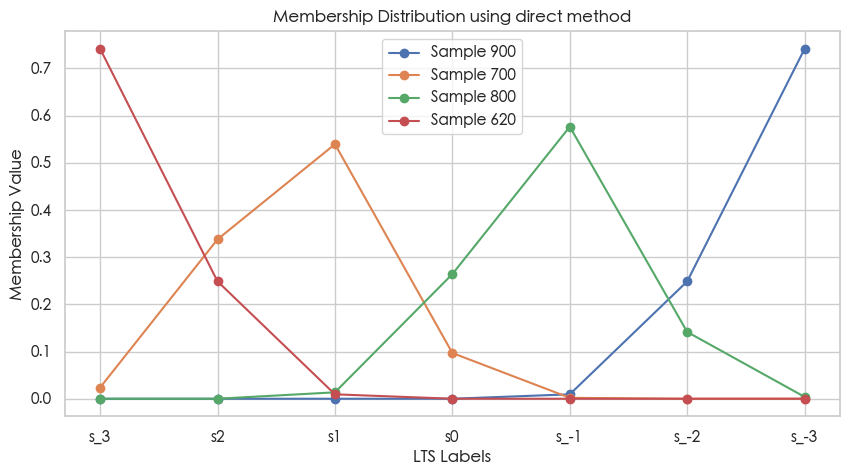

PLTS Results using direct method with pruning threshold 0.09:
Sample 900: {'s_-2': 0.25, 's_-3': 0.75}
Sample 700: {'s2': 0.35, 's1': 0.55, 's0': 0.1}
Sample 800: {'s0': 0.27, 's_-1': 0.59, 's_-2': 0.14}
Sample 620: {'s_3': 0.75, 's2': 0.25}


In [57]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, center_num,method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, center_num+1)
        lts_centers = (value_range[:-1] + value_range[1:]) / 2
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, center_num)
    return lts_centers

def gaussian_diffusion(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()
    return memberships

def format_plts_output(memberships, lts_labels, filter_zero=True):
    results = []
    for membership in memberships:
        if filter_zero:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 1e-3}
        else:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership)}
        results.append(result)
    return results
# 剔除隶属度低于给定阈值的结果，并对剩余的隶属度进行归一化处理。对于小于0.01的隶属度信息实际应用中参考价值过低，考虑剔除。
def prune_and_normalize_memberships(memberships, lts_labels, threshold):
    pruned_results = []
    for membership in memberships:
        pruned = {label: score for label, score in zip(lts_labels, membership) if score > threshold}
        total = sum(pruned.values())
        normalized = {label: np.round(score / total, 2) for label, score in pruned.items()}
        pruned_results.append(normalized)
    return pruned_results

# 样本数据和设置
samples = np.array([900,700,800,620])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
lts_labels = lts_labels[::-1] #经济型指标，需要对lts翻转

std_dev_ratio = 0.3  # Ratio to calculate dynamic std_dev
#常见的 std_dev_ratio 范围从 0.1 到 1，具体取决于数据的分布和分析需求。
# •	较小的比例（0.1 - 0.3）：适用于希望扩散效果较细腻，隶属度函数较尖锐的场景，有助于突出数据点之间的差异。
# •	较大的比例（0.5 - 1）：适用于需要较宽扩散覆盖，隶属度函数较平滑的场景，有助于平滑数据的随机波动，适用于数据点较为稀疏或分布较广的情况。
sample_std = np.std(samples)
std_dev = sample_std * std_dev_ratio
prune_threshold = 0.09  # 隶属度小于此值的将被剔除

# 用户选择
method_choice = 'direct'  # 'average' or 'direct'
output_filter_zero = True  # True to filter zero memberships, False to show all

# 生成LTS中心点
center_num = len(lts_labels)
lts_centers = generate_lts_centers(samples,center_num, method=method_choice)

# 计算隶属度
memberships = calculate_membership(samples, lts_centers, std_dev)

# 格式化PLTS输出
plts_results = format_plts_output(memberships, lts_labels, filter_zero=output_filter_zero)

# 剪裁和归一化隶属度
pruned_plts = prune_and_normalize_memberships(memberships, lts_labels, prune_threshold)

# 可视化隶属度分布
plt.figure(figsize=(10, 5))
for i, sample in enumerate(samples):
    plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}')
plt.title(f'Membership Distribution using {method_choice} method')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend()
plt.grid(True)
plt.show()

# 输出每个样本的PLTS结果
# print(f"PLTS Results using {method_choice} method with {'filtered' if output_filter_zero else 'full'} output:")
# for i, result in enumerate(plts_results):
#     print(f"Sample {samples[i]}: {result}")
# 输出裁剪后的PLTS结果
print(f"PLTS Results using {method_choice} method with pruning threshold {prune_threshold}:")
for i, result in enumerate(pruned_plts):
    print(f"Sample {samples[i]}: {result}")

In [55]:
lts_labels

['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']

### std_ratio 敏感性分析

#### 以某一个sample视角

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, center_num, method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, center_num + 1)
        lts_centers = (value_range[:-1] + value_range[1:]) / 2
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, center_num)
    return lts_centers

def gaussian_diffusion(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # Normalize memberships
    return memberships

def format_plts_output(memberships, lts_labels, filter_zero=True):
    results = []
    for membership in memberships:
        if filter_zero:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 1e-3}
        else:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership)}
        results.append(result)
    return results

# 剔除隶属度低于给定阈值的结果，并对剩余的隶属度进行归一化处理。对于小于0.01的隶属度信息实际应用中参考价值过低，考虑剔除。
def prune_and_normalize_memberships(memberships, lts_labels, threshold):
    pruned_results = []
    for membership in memberships:
        pruned = {label: score for label, score in zip(lts_labels, membership) if score > threshold}
        total = sum(pruned.values())
        normalized = {label: np.round(score / total, 2) for label, score in pruned.items()}
        pruned_results.append(normalized)
    return pruned_results

# 样本数据和设置
# samples = np.array([400, 700, 900, 680])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
prune_threshold = 0.01  # 隶属度小于此值的将被剔除

# 用户选择
method_choice = 'average'  # 'average' or 'direct'
output_filter_zero = True  # True to filter zero memberships, False to show all
center_num = len(lts_labels)

# 遍历 std_dev_ratio 从 0.1 到 1，进行可视化对比
std_dev_ratios = np.linspace(0.1, 1, 5)  # 从0.1到1，生成10个点
plt.figure(figsize=(12, 8))

for ratio in std_dev_ratios:
    # 计算动态标准差
    sample_std = np.std(samples)
    std_dev = sample_std * ratio
    
    # 生成LTS中心点
    lts_centers = generate_lts_centers(samples, center_num, method=method_choice)

    # 计算隶属度
    memberships = calculate_membership(samples, lts_centers, std_dev)

    # 格式化PLTS输出
    plts_results = format_plts_output(memberships, lts_labels, filter_zero=output_filter_zero)

    # 剪裁和归一化隶属度
    pruned_plts = prune_and_normalize_memberships(memberships, lts_labels, prune_threshold)

    # 可视化隶属度分布
    plt.plot(lts_labels, memberships[0], marker='o', label=f'Ratio {ratio:.2f}')

# 设置图形显示
plt.title(f'Membership Distribution using {method_choice} method for various std_dev_ratios')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend(title='std_dev_ratio')
plt.grid(True)
plt.show()

# 输出每个样本的PLTS结果
for ratio in std_dev_ratios:
    print(f"\nPLTS Results for std_dev_ratio {ratio:.2f} using {method_choice} method:")
    sample_std = np.std(samples)
    std_dev = sample_std * ratio
    lts_centers = generate_lts_centers(samples, center_num, method=method_choice)
    memberships = calculate_membership(samples, lts_centers, std_dev)
    pruned_plts = prune_and_normalize_memberships(memberships, lts_labels, prune_threshold)
    for i, result in enumerate(pruned_plts):
        print(f"Sample {samples[i]}: {result}")

#### 全局比较视角

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_lts_centers(samples, center_num, method='average'):
    sample_min = np.min(samples)
    sample_max = np.max(samples)
    if method == 'average':
        value_range = np.linspace(sample_min, sample_max, center_num + 1)
        lts_centers = (value_range[:-1] + value_range[1:]) / 2
    elif method == 'direct':
        lts_centers = np.linspace(sample_min, sample_max, center_num)
    return lts_centers

def gaussian_diffusion(x, mean, std_dev):
    return np.exp(-0.5 * ((x - mean) / std_dev)**2) / (std_dev * np.sqrt(2 * np.pi))

def calculate_membership(samples, lts_centers, std_dev):
    memberships = np.zeros((len(samples), len(lts_centers)))
    for i, sample in enumerate(samples):
        for j, center in enumerate(lts_centers):
            memberships[i, j] = gaussian_diffusion(sample, center, std_dev)
        memberships[i, :] /= memberships[i, :].sum()  # Normalize memberships
    return memberships

def format_plts_output(memberships, lts_labels, filter_zero=True):
    results = []
    for membership in memberships:
        if filter_zero:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership) if score > 1e-3}
        else:
            result = {label: np.round(score, 2) for label, score in zip(lts_labels, membership)}
        results.append(result)
    return results

# 剔除隶属度低于给定阈值的结果，并对剩余的隶属度进行归一化处理。对于小于0.01的隶属度信息实际应用中参考价值过低，考虑剔除。
def prune_and_normalize_memberships(memberships, lts_labels, threshold):
    pruned_results = []
    for membership in memberships:
        pruned = {label: score for label, score in zip(lts_labels, membership) if score > threshold}
        total = sum(pruned.values())
        normalized = {label: np.round(score / total, 2) for label, score in pruned.items()}
        pruned_results.append(normalized)
    return pruned_results

# 样本数据和设置
samples = np.array([400, 700, 900, 600])
lts_labels = ['s_-3', 's_-2', 's_-1', 's0', 's1', 's2', 's_3']
prune_threshold = 0.01  # 隶属度小于此值的将被剔除

# 用户选择
method_choice = 'average'  # 'average' or 'direct'
output_filter_zero = True  # True to filter zero memberships, False to show all
center_num = len(lts_labels)

# 遍历 std_dev_ratio 从 0.1 到 1，进行可视化对比
std_dev_ratios = np.linspace(0.1, 0.8, 4)  # 从0.1到1，生成10个点
plt.figure(figsize=(12, 8))

# 计算并绘制不同std_dev_ratio下的隶属度分布
for ratio in std_dev_ratios:
    # 计算动态标准差
    sample_std = np.std(samples)
    std_dev = sample_std * ratio
    
    # 生成LTS中心点
    lts_centers = generate_lts_centers(samples, center_num, method=method_choice)

    # 计算隶属度
    memberships = calculate_membership(samples, lts_centers, std_dev)

    # 可视化隶属度分布（叠加到同一图上）
    for i, sample in enumerate(samples):
        plt.plot(lts_labels, memberships[i], marker='o', label=f'Sample {sample}, Ratio {ratio:.2f}' if i == 0 else "", alpha=0.7)

# 设置图形显示
plt.title(f'Membership Distribution using {method_choice} method for various std_dev_ratios')
plt.xlabel('LTS Labels')
plt.ylabel('Membership Value')
plt.legend(title='std_dev_ratio', loc='best', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出每个样本的PLTS结果
for ratio in std_dev_ratios:
    print(f"\nPLTS Results for std_dev_ratio {ratio:.2f} using {method_choice} method:")
    sample_std = np.std(samples)
    std_dev = sample_std * ratio
    lts_centers = generate_lts_centers(samples, center_num, method=method_choice)
    memberships = calculate_membership(samples, lts_centers, std_dev)
    pruned_plts = prune_and_normalize_memberships(memberships, lts_labels, prune_threshold)
    for i, result in enumerate(pruned_plts):
        print(f"Sample {samples[i]}: {result}")

## Case Data- 问题背景：

    假设将在一个大城市举行一次国际级会议，预计将有数千名来自世界各地的代表参加。公安部门负责会议的安保工作，目的是确保会议期间的安全和秩序。由于资源有限，需要通过多属性决策分析（MCDA）方法来评估和选择最合适的安保方案。
- 决策目标：
    主要目标是确保会议的顺利进行，防止任何安全威胁，包括恐怖袭击、抗议活动和突发事件，并最小化对会议正常运行和城市日常生活的干扰。
- 决策标准：

	1.	安全性：方案能够有效预防和应对安全威胁的能力。
	2.	成本：实施方案所需的总成本，包括人员、设备和技术系统的费用。
	3.	公众影响：方案对会议参与者和市民日常活动的影响程度。
	4.	灵活性：方案对突发事件响应的适应能力。
	5. 技术支持：利用现代技术提升安保效果的能力
	 
- 方案选项

    - 方案A ：高强度安保部署。包括大量警力部署、全面的视频监控和严格的入场检查。
	- 方案B：中度安保部署。警力部署较方案A少，侧重于关键区域的监控，入场检查适度。
	- 方案C：技术驱动方案。依赖高科技监控系统和数据分析，减少人力部署，重点监控可疑行为。
- 权重：
    假设安全形势较为紧张，权重分配如下：

        安全性：40% Safety（S）
        成本：20% Cost（C）
        公众影响：15% Public Impact (PI)
        灵活性：15% Flexibility (F)
        技术支持：10% Technology Support (TS)
- Sample

        # lts: s_-3 s_-2  s_-1 s_0 s_1 s_2  s_3
        
        标准	    方案A	方案B	方案C
    
        安全性     	{(s_2|0.3),(s_3|0.7)} 	{(s_1|0.5),(s_2|0.5)}	{(s_2|0.9),(s_3|0.1)}
    
        成本	        9	7	6
    
        公众影响    	{(s_1|0.4), (s_0|0.4), (s_-1|0.2)}	{(s_-1|0.3),(s_0|0.7)}	{(s_0|0.7),(s_1|0.3)}
    
        灵活性	    {(s_-2|0.5), (s_-1|0.3), (s_0|0.2)}	{((s_0|0.6),(s_1|0.4)}	{(s_1|0.4),(s_2|0.6)}
    
        技术支持      {(s_1|0.3), (s_0|0.5), (s_-1|0.2)} 	{(s_1|0.5),(s_2|0.5)}	{(s_2|0.6),(s_3|0.4)} 
        

            - 方案A涉及大量警力部署、全面的视频监控和严格的入场检查，强调高强度的安全防范。因此，安全性、成本和灵活性需要表现出更高的要求，而公众影响则可能相对较大。
            
            - 方案B使用较少的警力，重点监控关键区域，入场检查适度，因此在安全性和灵活性上表现较为平衡
            
            -方案C依赖高科技监控系统和数据分析，减少人力部署，重点监控可疑行为，因此在安全性和成本上表现较为平衡
            
             	•	方案A（高强度安保部署）依赖大量警力和设备，安全性和成本较高，灵活性较低，公众影响较大。
                •	方案B（中度安保部署）具有较为平衡的安全性、成本和灵活性，适应性较强，技术支持中等。
                •	方案C（技术驱动方案）依赖高科技监控，成本较低，安全性较高，但灵活性较差，技术支持为关键因素。

             
        
            

### Data Preparation

In [7]:
# n =4 m =6
# language scale =7 
# 成本：900 700 800 620
# PLTS Results using average method with pruning threshold 0.1:
# Sample 450: {'s_3': 0.85, 's_2': 0.15}
# Sample 700: {'s0': 0.55, 's-1': 0.45}
# Sample 900: {'s_-2': 0.15, 's_-3': 0.85}
# Sample 620: {'s_2': 0.17, 's_1': 0.54, 's0': 0.29}
#   1.	安全性：方案能够有效预防和应对安全威胁的能力。
# 	2.	成本：实施方案所需的总成本，包括人员、设备和技术系统的费用。
# 	3.	公众影响：方案对会议参与者和市民日常活动的影响程度。
# 	4.	灵活性：方案对突发事件响应的适应能力。
# 	5. 技术支持：利用现代技术提升安保效果的能力
plts_matrix = [
    # A 高强度安保部署
    [
        PLTS({"s3": 0.5, "s2": 0.3, "s1": 0.2}), 
        PLTS({'s-2': 0.25, 's-3': 0.75}),
	    PLTS({"s-2": 0.6, "s-1": 0.2, "s0": 0.2}),
	    PLTS({"s-1": 0.5, "s-2": 0.4, "s0": 0.1}),
	    PLTS({"s1": 0.8, "s0": 0.2})
    ],
    #B 中度安保部署
    [
        PLTS({"s2": 0.4, "s1": 0.4, "s0": 0.2}),
        PLTS({'s2': 0.35, 's1': 0.55, 's0': 0.1}),
        PLTS({"s0": 0.6, "s1": 0.2, "s-1": 0.2}),
        PLTS({"s1": 0.5, "s0": 0.3, "s2": 0.2}),
        PLTS({"s2": 0.4, "s1": 0.4, "s0": 0.2})
    ],
    #C 技术驱动方案
    [
        PLTS({"s3": 0.7, "s2": 0.2, "s1": 0.1}),
        PLTS({'s0': 0.27, 's-1': 0.59, 's-2': 0.14}),
        PLTS({"s-1": 0.8, "s-2": 0.2}),
        PLTS({"s1": 0.5, "s0": 0.3, "s-1": 0.2}),
        PLTS({"s3": 0.8, "s2": 0.1, "s1": 0.1}) 
    ],
    # D：环保技术方案
    [
        PLTS({"s2": 0.4, "s1": 0.3, "s0": 0.3}),   
        PLTS({'s3': 0.75, 's2': 0.25}),
        PLTS({"s1": 0.6, "s0": 0.3, "s-1": 0.1}),
        PLTS({"s0": 0.4, "s1": 0.6}),
        PLTS({"s-2": 0.5, "s-1": 0.4, "s1": 0.1}) 
    ]
    
    
    
]

# laguage scale =7 
lts_n = 7 

# 权重
weights = [0.3, 0.15, 0.3, 0.15, 0.1]  # Weights for each criterion


### Processing

#### Context Matrix and Aggregations 

In [9]:
# Context Matrix and Aggregations 
evaluation_matrix = PLTSEvaluationMatrix(plts_matrix, weights, lts_n, True)
all_matrices_SM = evaluation_matrix.calculate_matrices_SM()
all_matrices_IM = evaluation_matrix.calculate_matrices_IM()

# calculate the sum of all_matrices_SM
score_SM = np.sum(all_matrices_SM, axis=(1, 2))
score_SM /= np.sum(score_SM)
score_IM = np.sum(all_matrices_IM, axis=(1, 2))
score_IM /= np.sum(score_IM)

# Prospect theory
α = β = 0.88
λ = 2.25

PV = [
    prospect(score_SM[i], α, β, λ) + prospect(score_IM[i], α, β, λ)
    for i in range(len(score_SM))
]

print(score_SM)
print(score_IM)

print(PV)

[0.33179653 0.16537561 0.35579532 0.14703254]
[-2.56243029e-04  3.81091960e-01  2.72360343e-01  3.46803940e-01]
[0.2556693549657539, 0.4250694911371481, 0.4872416083231055, 0.38802313745556594]


In [38]:
np.sum(all_matrices_IM, axis=(1, 2))

array([0.08742311, 3.87411049, 2.79746268, 3.52554481])

In [45]:
print([prospect(score_SM[i], α, β, λ) for i in range(len(score_SM))])
print([prospect(score_IM[i], α, β, λ) for i in range(len(score_SM))])

[1.5380063554837866, 1.044668424313124, 1.5659719846240705, 0.9766742162605322]
[-0.166762287924277, -3.338318644752284, -2.7940031948203816, -3.176080945001462]


### Visulization

In [ ]:
### Visulization

import seaborn as sns
sns.set_theme(style="whitegrid",font="STHeiti Medium.ttc",font_scale=1.5)

# 设置雷达图的标签
labels = ['Superior', 'Inferior (Negative)', 'Prospect Theory Value']

# 计算每个方案的表现
values = np.array([score_SM, score_IM, PV])

# 为了使雷达图闭环，添加一个额外的数据点到数组的末尾
values = np.vstack([values, values[0]])  # 将数据环绕形成闭环

# 设置角度，使得每个标准占据一个扇形
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# 使得雷达图闭环（最后一个角度与第一个角度重合）
angles += angles[:1]

# 创建雷达图
fig, ax = plt.subplots(figsize=(8, 8), dpi=100, subplot_kw=dict(polar=True))

# 绘制每个方案的雷达图
ax.plot(angles, values[0], label='方案A', linewidth=2, linestyle='solid', color='blue')
ax.fill(angles, values[0], color='blue', alpha=0.3)

ax.plot(angles, values[1], label='方案B', linewidth=2, linestyle='solid', color='green')
ax.fill(angles, values[1], color='green', alpha=0.3)

ax.plot(angles, values[2], label='方案C', linewidth=2, linestyle='solid', color='red')
ax.fill(angles, values[2], color='red', alpha=0.3)

ax.plot(angles, values[3], label='方案D', linewidth=2, linestyle='solid', color='purple')
ax.fill(angles, values[3], color='purple', alpha=0.3)

# 添加标题
ax.set_title("Evaluation Results of Security Plans", fontsize=16, fontweight='bold')

# 设置标签和刻度
ax.set_xticks(angles[:-1])  # 排除最后一个角度
ax.set_xticklabels(labels, fontsize=12)
ax.set_yticklabels([])  # 移除y轴标签，因为雷达图不需要y轴显示

# 设置图例
plt.legend(loc='upper right', fontsize=12)

# 显示图表
plt.show()

In [ ]:
# 设置方案名称
plans = ['方案A', '方案B', '方案C', '方案D']

# 为每个方案绘制堆叠条形图
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

bar_width = 0.35
index = np.arange(len(plans))

# 绘制堆叠条形图
ax.bar(index, score_SM, bar_width, label="Superior", color="lightgreen")
ax.bar(index, score_IM, bar_width, bottom=score_SM, label="Inferior (Negative)", color="salmon")

# 添加 Prospect Theory Value
ax.bar(index + bar_width, PV, bar_width, label="Prospect Theory Value", color="skyblue")

# 添加标签和标题
ax.set_xlabel("备选方案", fontsize=14)
ax.set_ylabel("数值", fontsize=14)
ax.set_title("前景理论与决策方案的关系", fontsize=16)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(plans, fontsize=12)
ax.legend(fontsize=12)

# 添加数值注释
for i in range(len(plans)):
    ax.text(i, score_SM[i] + score_IM[i] + 0.02, f"{score_SM[i]:.2f}", ha="center", fontsize=10)
    ax.text(i, score_SM[i] + 0.02, f"{score_IM[i]:.2f}", ha="center", fontsize=10)
    ax.text(i + bar_width, PV[i] + 0.02, f"{PV[i]:.2f}", ha="center", fontsize=10)

# 显示图表
plt.show()

#### 中文字体


In [ ]:
from matplotlib.font_manager import FontManager

mac_fonts = set(f.name for f in FontManager().ttflist)

print('all font list get from matplotlib.font_manager:')

for f in sorted(mac_fonts):
    print('\t'+f)

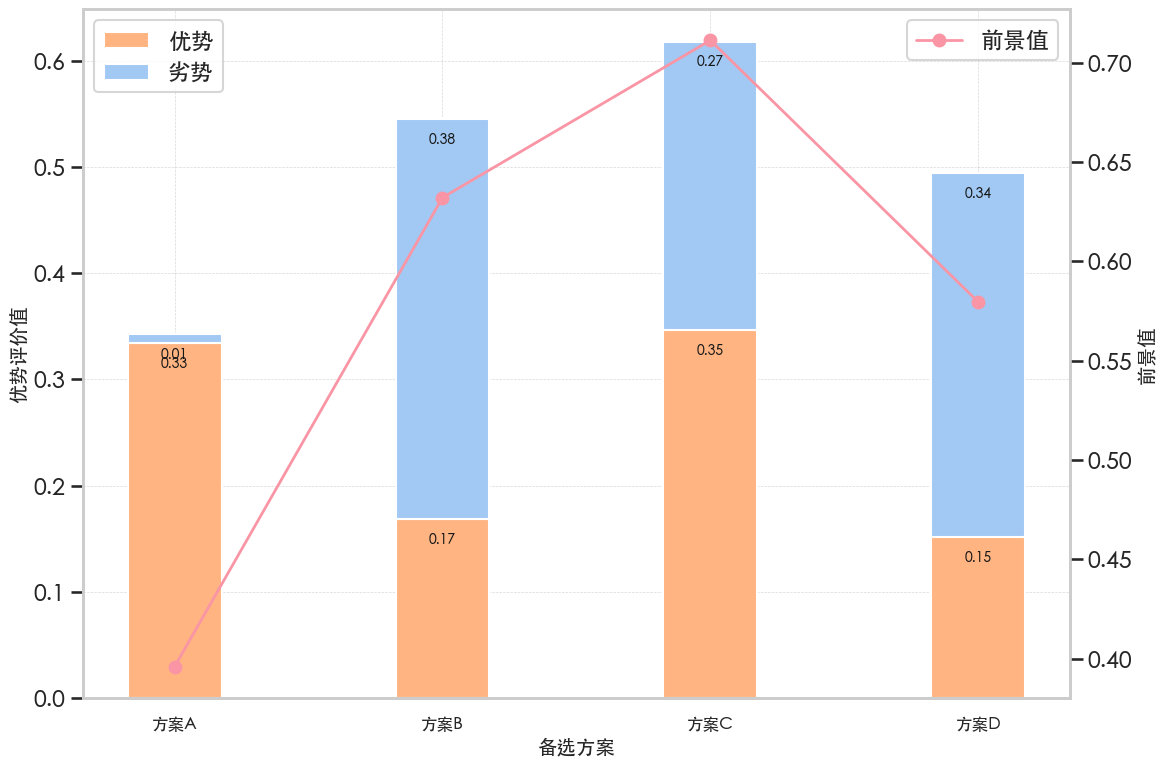

In [9]:
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# 设置方案名称
plans = ['方案A', '方案B', '方案C', '方案D']
# from matplotlib import font_manager
# # 设置字体路径
# font_path = '/Users/hao/Library/Fonts/微软雅黑.ttf'  # 根据你的系统调整路径
# prop = font_manager.FontProperties(fname=font_path)

# import matplotlib

# 设置matplotlib使用的中文字体
# matplotlib.rcParams['font.family'] = 'Microsoft YaHei'  # 这里可以根据你的系统设置更改字体
# plt.rcParams['font.family'] = 'Microsoft YaHei'  # 使用 macOS 上的中文字体
# # matplotlib.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
# 
# matplotlib.rcParams['font.sans-serif'] =  ['Microsoft YaHei']

# matplotlib.rcParams['font.serif'] =  ['Heiti TC']

# matplotlib.rcParams['axes.unicode_minus'] = False

# sns.set_theme(font="Arial Unicode MS",style="whitegrid")

sns.set_theme(font="Heiti TC",style="whitegrid",context="talk",palette="pastel")
# plt.rcParams['font.family']=['Microsoft YaHei'] 

# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

# 创建一个具有两个Y轴的复合图
# 创建图表
fig, ax1 = plt.subplots(figsize=(12, 8))

# 设置柱状图
bar_width = 0.35
index = np.arange(len(plans))

# 绘制柱状图
bars1 = ax1.bar(index, score_SM, bar_width, label="优势", color=sns.color_palette()[1])
bars2 = ax1.bar(index, score_IM, bar_width, bottom=score_SM, label="劣势", color=sns.color_palette()[0])

# 添加数值注释
for rect in bars1 + bars2:
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + height - 0.025,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='#181818')


# 设置第一个Y轴
ax1.set_xlabel("备选方案", fontsize=14)
ax1.set_ylabel("优势评价值", fontsize=14)
ax1.set_xticks(index)
ax1.set_xticklabels(plans, fontsize=12)

# 绘制第二个Y轴（折线图）
ax2 = ax1.twinx()
ax2.plot(index , PV, color="#FA95A5", marker='o', label="前景值", linewidth=2, linestyle='-') 
ax2.set_ylabel("前景值", fontsize=14)

# 调整网格线样式
ax1.grid(True, linestyle='--', linewidth='0.5', color='grey', alpha=0.3)
ax2.grid(False)  # 可能需要关闭第二个Y轴的网格线

# 设置图例
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# 设置标题
# plt.title("前景理论与决策方案的关系", fontsize=16)
plt.tight_layout()  # 自动调整子图参数


In [87]:

print(score_SM)
print(score_IM)


[0.33410137 0.16840397 0.34616879 0.15132586]
[0.00850044 0.3766926  0.27200656 0.3428004 ]


# Comparison

In [24]:
plts_matrix = [
    # A 高强度安保部署
    [
        PLTS({"s3": 0.5, "s2": 0.3, "s1": 0.2}), 
        PLTS({'s-2': 0.25, 's-3': 0.75}),
	    PLTS({"s-2": 0.6, "s-1": 0.2, "s0": 0.2}),
	    PLTS({"s-1": 0.5, "s-2": 0.4, "s0": 0.1}),
	    PLTS({"s1": 0.8, "s0": 0.2})
    ],
    #B 中度安保部署
    [
        PLTS({"s2": 0.4, "s1": 0.4, "s0": 0.2}),
        PLTS({'s2': 0.35, 's1': 0.55, 's0': 0.1}),
        PLTS({"s0": 0.6, "s1": 0.2, "s-1": 0.2}),
        PLTS({"s1": 0.5, "s0": 0.3, "s2": 0.2}),
        PLTS({"s2": 0.4, "s1": 0.4, "s0": 0.2})
    ],
    #C 技术驱动方案
    [
        PLTS({"s3": 0.7, "s2": 0.2, "s1": 0.1}),
        PLTS({'s0': 0.27, 's-1': 0.59, 's-2': 0.14}),
        PLTS({"s-1": 0.8, "s-2": 0.2}),
        PLTS({"s1": 0.5, "s0": 0.3, "s-1": 0.2}),
        PLTS({"s3": 0.8, "s2": 0.1, "s1": 0.1}) 
    ],
    # D：环保技术方案
    [
        PLTS({"s2": 0.4, "s1": 0.3, "s0": 0.3}),   
        PLTS({'s3': 0.75, 's2': 0.25}),
        PLTS({"s1": 0.6, "s0": 0.3, "s-1": 0.1}),
        PLTS({"s0": 0.4, "s1": 0.6}),
        PLTS({"s-2": 0.5, "s-1": 0.4, "s1": 0.1}) 
    ]
    
    
    
]

# laguage scale =7 
lts_n = 7 

# 权重
weights = [0.3, 0.15, 0.3, 0.15, 0.1]  # Weights for each criterion


n = len(plts_matrix)
m = len(weights)
DM = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        DM[i][j] = np.sum(plts_matrix[i][j].score())


import numpy as np

# 评分映射
score_map = {'s3': 3, 's2': 2, 's1': 1, 's0': 0, 's-1': -1, 's-2': -2, 's-3': -3}

# 定义PLTS数据
plts_data = [
    [{"s3": 0.5, "s2": 0.3, "s1": 0.2}, {'s-2': 0.25, 's-3': 0.75}, {"s-2": 0.6, "s-1": 0.2, "s0": 0.2}, {"s-1": 0.5, "s-2": 0.4, "s0": 0.1}, {"s1": 0.8, "s0": 0.2}],
    [{"s2": 0.4, "s1": 0.4, "s0": 0.2}, {'s2': 0.35, 's1': 0.55, 's0': 0.1}, {"s0": 0.6, "s1": 0.2, "s-1": 0.2}, {"s1": 0.5, "s0": 0.3, "s2": 0.2}, {"s2": 0.4, "s1": 0.4, "s0": 0.2}],
    [{"s3": 0.7, "s2": 0.2, "s1": 0.1}, {'s0': 0.27, 's-1': 0.59, 's-2': 0.14}, {"s-1": 0.8, "s-2": 0.2}, {"s1": 0.5, "s0": 0.3, "s-1": 0.2}, {"s3": 0.8, "s2": 0.1, "s1": 0.1}],
    [{"s2": 0.4, "s1": 0.3, "s0": 0.3}, {'s3': 0.75, 's2': 0.25}, {"s1": 0.6, "s0": 0.3, "s-1": 0.1}, {"s0": 0.4, "s1": 0.6}, {"s-2": 0.5, "s-1": 0.4, "s1": 0.1}]
]

# 转换PLTS数据为期望值
def convert_plts_to_expectation(plts):
    return sum(score_map[level] * prob for level, prob in plts.items())

# 计算每个方案的期望值
expectations = np.array([[convert_plts_to_expectation(plts) for plts in alternative] for alternative in plts_data])

# 定义权重
weights = np.array([0.3, 0.15, 0.3, 0.15, 0.1])

# 计算TODIM支配度
theta = 2.25  # 风险规避参数
n_alternatives = len(plts_data)
dominance_matrix = np.zeros((n_alternatives, n_alternatives))

for i in range(n_alternatives):
    for j in range(n_alternatives):
        if i != j:
            gain = np.maximum(0, expectations[i] - expectations[j])
            loss = np.maximum(0, expectations[j] - expectations[i])
            dominance_matrix[i, j] = np.sum(weights * (gain - theta * loss))

# 归一化支配度
normalized_dominance = dominance_matrix.sum(axis=1) - dominance_matrix.sum(axis=0)
normalized_dominance /= np.abs(normalized_dominance).sum()

print("Normalized Dominance Scores:", normalized_dominance)





Normalized Dominance Scores: [-0.5         0.19920844  0.06860158  0.23218997]


In [28]:
# 采用文献中的TODIM：

n = len(plts_matrix)
m = len(weights)
DM = np.zeros((n, m))
for i in range(n):
    for j in range(m):
        DM[i][j] = np.sum(plts_matrix[i][j].score())


# Define the performance matrix (alternatives x criteria)
performance_matrix = DM+1 # to avoid zero

# Define the weights of the criteria
weights = np.array(weights)

# Number of alternatives and criteria
n_alternatives = performance_matrix.shape[0]
n_criteria = performance_matrix.shape[1]

# Normalize the performance matrix
normalized_matrix = performance_matrix / (
    np.max(performance_matrix, axis=0) - np.min(performance_matrix, axis=0)
)  # performance_matrix.sum(axis=0)
# normalized_matrix = performance_matrix
# Compute the weighted normalized decision matrix
weighted_normalized_matrix = normalized_matrix * weights

# Compute the TODIM index for each alternative
todim_index = np.zeros(n_alternatives)
for i in range(n_alternatives):
    for j in range(n_alternatives):
        if i != j:
            for k in range(n_criteria):
                todim_index[i] += (
                    weighted_normalized_matrix[i, k] - weighted_normalized_matrix[j, k]
                ) * (
                    weighted_normalized_matrix[i, k] / weighted_normalized_matrix[j, k]
                ) ** 2

# Print the TODIM index for each alternative
print("TODIM index:", todim_index)


TODIM index: [ -6.67776624  32.88402803  19.23201761 105.92905295]


In [25]:
expectations

array([[ 2.3 , -2.75, -1.4 , -1.3 ,  0.8 ],
       [ 1.2 ,  1.25,  0.  ,  0.9 ,  1.2 ],
       [ 2.6 , -0.87, -1.2 ,  0.3 ,  2.7 ],
       [ 1.1 ,  2.75,  0.5 ,  0.6 , -1.3 ]])

In [49]:
## TOPSIS 

def topsis(decision_matrix, weights):
    # Normalize the decision matrix
    normalized_matrix = decision_matrix / np.sqrt((decision_matrix**2).sum(axis=0))

    # Multiply each criterion by its weight
    weighted_matrix = normalized_matrix * weights

    # Determine the ideal and negative-ideal solutions
    ideal_solution = np.max(weighted_matrix, axis=0)
    negative_ideal_solution = np.min(weighted_matrix, axis=0)

    # Calculate the distance to the ideal and negative-ideal solutions
    distance_to_ideal = np.linalg.norm(weighted_matrix - ideal_solution, axis=1)
    distance_to_negative_ideal = np.linalg.norm(
        weighted_matrix - negative_ideal_solution, axis=1
    )

    # Calculate the relative closeness to the ideal solution
    closeness = distance_to_negative_ideal / (
        distance_to_ideal + distance_to_negative_ideal
    )

    # Rank the alternatives based on the relative closeness
    ranking = np.argsort(closeness)[::-1]

    return ranking,closeness


is_benefit = np.array([True] * m)
ranking,closeness = topsis(DM, weights)  # high to low
print(ranking,closeness)

[3 1 2 0] [0.21595856 0.68729346 0.43368303 0.69870028]


## Comparison Visualizaiton

In [12]:
import numpy as np

# 评分映射
score_map = {'s3': 1, 's2': 0.75, 's1': 0.5, 's0': 0.25, 's-1': 0, 's-2': -0.25, 's-3': -0.5}

# 权重数组
weights = np.array([0.3, 0.15, 0.3, 0.15, 0.1] )


# 定义PLTS矩阵
plts_matrix = [
    # A 高强度安保部署
    [{"s3": 0.5, "s2": 0.3, "s1": 0.2}, {'s-2': 0.25, 's-3': 0.75}, {"s-2": 0.6, "s-1": 0.2, "s0": 0.2}, {"s-1": 0.5, "s-2": 0.4, "s0": 0.1}, {"s1": 0.8, "s0": 0.2}],
    # B 中度安保部署
    [{"s2": 0.4, "s1": 0.4, "s0": 0.2}, {'s2': 0.35, 's1': 0.55, 's0': 0.1}, {"s0": 0.6, "s1": 0.2, "s-1": 0.2}, {"s1": 0.5, "s0": 0.3, "s2": 0.2}, {"s2": 0.4, "s1": 0.4, "s0": 0.2}],
    # C 技术驱动方案
    [{"s3": 0.7, "s2": 0.2, "s1": 0.1}, {'s0': 0.27, 's-1': 0.59, 's-2': 0.14}, {"s-1": 0.8, "s-2": 0.2}, {"s1": 0.5, "s0": 0.3, "s-1": 0.2}, {"s3": 0.8, "s2": 0.1, "s1": 0.1}],
    # D 环保技术方案
    [{"s2": 0.4, "s1": 0.3, "s0": 0.3}, {'s3': 0.75, 's2': 0.25}, {"s1": 0.6, "s0": 0.3, "s-1": 0.1}, {"s0": 0.4, "s1": 0.6}, {"s-2": 0.5, "s-1": 0.4, "s1": 0.1}]
]

def calculate_wsm(plts):
    total_score = 0
    for criteria, plts_data in zip(weights, plts):
        exp_value = sum(score_map[level] * prob for level, prob in plts_data.items())
        total_score += criteria * exp_value
    return total_score

def calculate_wpm(plts):
    score_product = 1
    for criteria, plts_data in zip(weights, plts):
        exp_value = sum(score_map[level] * prob for level, prob in plts_data.items())
        score_product *= np.power(exp_value + 1, criteria)  # Adding 1 to avoid negative or zero base for power
    return score_product

# 计算WSM和WPM得分
wsm_scores = [calculate_wsm(plts) for plts in plts_matrix]
wpm_scores = [calculate_wpm(plts) for plts in plts_matrix]

print("WSM Scores:", wsm_scores)
print("WPM Scores:", wpm_scores)


WSM Scores: [0.18562499999999996, 0.450625, 0.40112500000000006, 0.46312499999999995]
WPM Scores: [1.0920136138059253, 1.4441007386275515, 1.3359866734513153, 1.4391014072136818]


## 决策结果

In [ ]:
normalized_dominance= [-0.5,0.19920844,0.06860158,0.23218997]
wsm_scores=[0.18562499999999996, 0.450625, 0.40112500000000006, 0.46312499999999995]
wpm_scores=[1.0920136138059253, 1.4441007386275515, 1.3359866734513153, 1.4391014072136818]

## Comparison Visualizaiton

### Origin

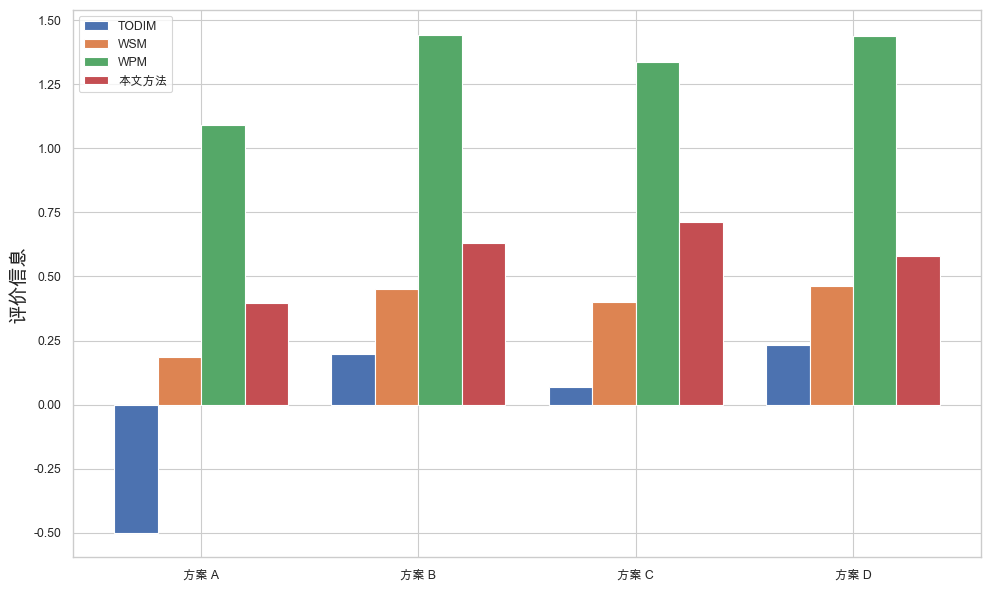

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 定义各决策方法得分
normalized_dominance = [-0.5, 0.19920844, 0.06860158, 0.23218997]
wsm_scores = [0.18562499999999996, 0.450625, 0.40112500000000006, 0.46312499999999995]
wpm_scores = [1.0920136138059253, 1.4441007386275515, 1.3359866734513153, 1.4391014072136818]
prospect_value_ours = [0.39614000905111313, 0.6320551698640963, 0.7111656573956393, 0.5796070515902454]

# 准备数据
methods = ['TODIM', 'WSM', 'WPM', '本文方法']
scores = np.array([normalized_dominance, wsm_scores, wpm_scores, prospect_value_ours])
scores = scores.T  # 转置以匹配方案

# 方案名称
plans = ['方案 A', '方案 B', '方案 C', '方案 D']

sns.set_theme(context="paper",style="whitegrid",font="Arial Unicode MS")
# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(plans))

for i in range(len(methods)):
    ax.bar(index + i * bar_width, scores[:, i], width=bar_width, label=methods[i])

# 添加标签和标题
# ax.set_xlabel('方案', fontsize=12)
ax.set_ylabel('评价信息', fontsize=14)
# ax.set_title('Comparison of Decision-Making Methods', fontsize=14)
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(plans)

ax.legend(loc="upper left",bbox to anchor=(0,0),bbox_transform=ax.transAxes, ncol=2, fontsize=12)

# 显示图形
plt.tight_layout()

plt.savefig( "Comparison_of_Decision-Making_Methods.png",dpi=300)
plt.show()

### Nomarlize

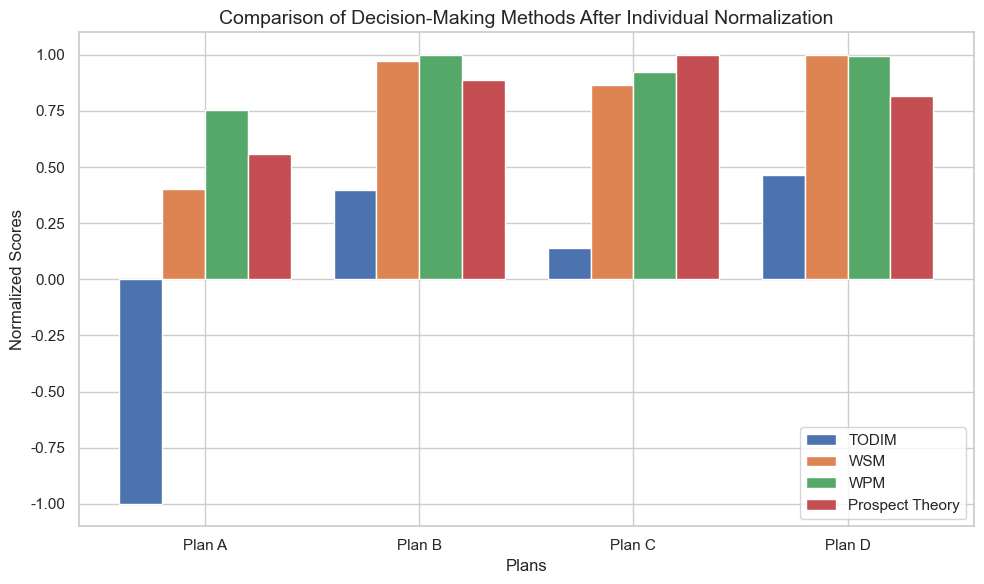

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# 设置绘图风格
sns.set(style="whitegrid")

# 定义各决策方法得分
scores = np.array([
    [-0.5, 0.19920844, 0.06860158, 0.23218997],  # TODIM
    [0.185625, 0.450625, 0.401125, 0.463125],     # WSM
    [1.092014, 1.444101, 1.335987, 1.439101],     # WPM
    [0.396140, 0.632055, 0.711166, 0.579607]      # Prospect Theory
]).T  # 转置使得行为方案，列为方法

# 独立归一化每种方法的得分
normalized_scores = np.zeros_like(scores)
for i in range(scores.shape[1]):
    scaler = MaxAbsScaler()  # MaxAbsScaler或 StandardScaler()
    normalized_scores[:, i] = scaler.fit_transform(scores[:, i:i+1]).flatten()

# 方案名称
plans = ['Plan A', 'Plan B', 'Plan C', 'Plan D']
methods = ['TODIM', 'WSM', 'WPM', 'Prospect Theory']

# 创建柱状图
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
index = np.arange(len(plans))

for i in range(len(methods)):
    ax.bar(index + i * bar_width, normalized_scores[:, i], width=bar_width, label=methods[i])

# 添加标签和标题
ax.set_xlabel('Plans', fontsize=12)
ax.set_ylabel('Normalized Scores', fontsize=12)
ax.set_title('Comparison of Decision-Making Methods After Individual Normalization', fontsize=14)
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(plans)
ax.legend()

# 显示图形
plt.tight_layout()
plt.show()

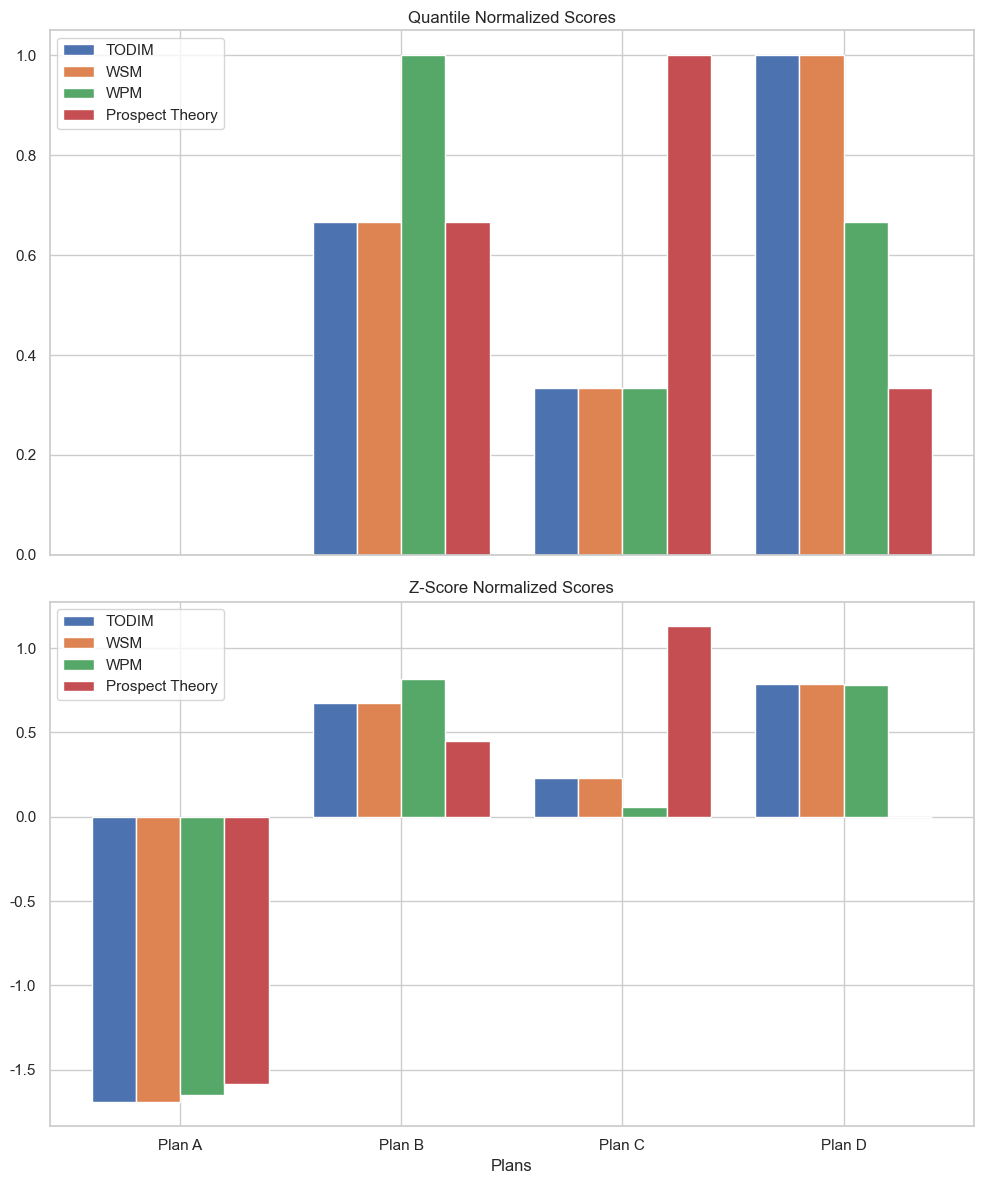

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import quantile_transform, StandardScaler

# 设置绘图风格
sns.set(style="whitegrid")

# 定义各决策方法得分
scores = np.array([
    [-0.5, 0.19920844, 0.06860158, 0.23218997],  # TODIM
    [0.185625, 0.450625, 0.401125, 0.463125],     # WSM
    [1.092014, 1.444101, 1.335987, 1.439101],     # WPM
    [0.396140, 0.632055, 0.711166, 0.579607]      # Prospect Theory
]).T  # 转置使得行为方案，列为方法

# 方案名称
plans = ['Plan A', 'Plan B', 'Plan C', 'Plan D']
methods = ['TODIM', 'WSM', 'WPM', 'Prospect Theory']

# 分位数归一化，调整 n_quantiles 至最大样本数
quantile_normalized_scores = np.zeros_like(scores)
for i in range(scores.shape[1]):
    quantile_normalized_scores[:, i] = quantile_transform(scores[:, i:i+1], n_quantiles=min(4, scores.shape[0]), random_state=0, copy=True, axis=0).flatten()

# Z-Score 归一化
z_normalized_scores = np.zeros_like(scores)
scaler = StandardScaler()
for i in range(scores.shape[1]):
    z_normalized_scores[:, i] = scaler.fit_transform(scores[:, i:i+1]).flatten()

# 创建柱状图比较两种归一化方法
fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# 分位数归一化图
for i in range(len(methods)):
    axs[0].bar(index + i * bar_width, quantile_normalized_scores[:, i], width=bar_width, label=methods[i])

axs[0].set_title('Quantile Normalized Scores')
axs[0].set_xticks(index + 1.5 * bar_width)
axs[0].set_xticklabels(plans)
axs[0].legend()

# Z-Score 归一化图
for i in range(len(methods)):
    axs[1].bar(index + i * bar_width, z_normalized_scores[:, i], width=bar_width, label=methods[i])

axs[1].set_title('Z-Score Normalized Scores')
axs[1].set_xlabel('Plans')
axs[1].set_xticks(index + 1.5 * bar_width)
axs[1].legend()

# 显示图形
plt.tight_layout()
plt.show()

In [14]:
quantile_normalized_scores


array([[0.        , 0.        , 0.        , 0.        ],
       [0.66666667, 0.66666667, 1.        , 0.66666667],
       [0.33333333, 0.33333333, 0.33333333, 1.        ],
       [1.        , 1.        , 0.66666667, 0.33333333]])